In [1]:
import bioframe
import cooler 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
from skimage.filters import threshold_li, threshold_otsu

import seaborn as sns

In [2]:
#### need the following for running fontanka #####
# 1. a regions file = ce10.chrom.sizes file viewframe format
# 2. hic file = coolformat
# 3. manually generated avfountains file = N-by-N log2(obs/exp), npy matrix, nan must be replaced with -inf (something to do with fountain script)


In [3]:
####################### run on bash ########################

#!/bin/bash

# cd /mnt/g/cohesin_paper

# 1. get expected from cooltools
# cooltools expected-cis ./ce10/Cool/JK07_JK08_30_2000_raw.cool --regions ./ce10/ce10_viewframe.tsv -p 24 --clr-weight-name weight --ignore-diags 2 -o ./ce10/expected/JK07_JK08_2000.expected.tsv
# cooltools expected-cis ./ce10/Cool/JK155_combined_JK181_30_2000_raw.cool --regions ./ce10/ce10_viewframe.tsv -p 24 --clr-weight-name weight --ignore-diags 2 -o ./ce10/expected/JK155_combined_JK181_2000.expected.tsv


# 2. get snips of all sliding windows
#fontanka slice-windows ./ce10/Cool/JK07_JK08_30_2000_raw.cool \
#        ./ce10/snips/JK07_JK08.100Kb.snips.npy \
#        -p 24 -W 100_000 \
#        --view ./ce10/ce10_viewframe.tsv \
#        --expected ./ce10/expected/JK07_JK08_2000.expected.tsv

#fontanka slice-windows ./ce10/Cool/JK155_combined_JK181_30_2000_raw.cool \
#        ./ce10/snips/JK155_combined_JK181.100Kb.snips.npy \
#        -p 24 -W 100_000 \
#        --view ./ce10/ce10_viewframe.tsv \
#        --expected ./ce10/expected/JK155_combined_JK181_2000.expected.tsv



# 3. get fountain score per snip using manually generated avfountain

#regions=("left" "center" "right")
 
#for r in "${regions[@]}"
#do
#fontanka apply-fountain-mask ./ce10/Cool/JK07_JK08_30_2000_raw.cool \
#        ./ce10/output/control_"$r".100Kb.output.tsv \
#        --snips ./ce10/snips/JK07_JK08.100Kb.snips.npy \
#        -W 100_000 \
#        -M ./ce10/avfountains/control_"$r"_avfountain.npy \
#        --view ./ce10/ce10_viewframe.tsv

#fontanka apply-fountain-mask ./ce10/Cool/JK155_combined_JK181_30_2000_raw.cool \
#        ./ce10/output/wapl_"$r".100Kb.output.tsv \
#        --snips ./ce10/snips/JK155_combined_JK181.100Kb.snips.npy \
#        -W 100_000 \
#        -M ./ce10/avfountains/wapl_"$r"_avfountain.npy \
#        --view ./ce10/ce10_viewframe.tsv
#done


In [3]:
stack_ctr = np.load("./ce10/snips/JK07_JK08.100Kb.snips.npy")
stack_wapl = np.load("./ce10/snips/JK155_combined_JK181.100Kb.snips.npy")

#df_score = pd.read_table("./ce10/JK07_JK08.sim.100Kb.output.tsv")

#df_score


In [185]:
ctr_center = pd.read_table("./ce10/output/control_center.100Kb.output.tsv")
ctr_left = pd.read_table("./ce10/output/control_left.100Kb.output.tsv")
ctr_right = pd.read_table("./ce10/output/control_right.100Kb.output.tsv")

wapl_center = pd.read_table("./ce10/output/wapl_center.100Kb.output.tsv")
wapl_left = pd.read_table("./ce10/output/wapl_left.100Kb.output.tsv")
wapl_right = pd.read_table("./ce10/output/wapl_right.100Kb.output.tsv")

ctr = [ctr_center,ctr_left,ctr_right]
wapl = [wapl_center,wapl_left,wapl_right]


In [186]:
#### function for thresholding #### based on fontanka
def call_fountains(fontanka_output, noise_th, peak_th, FS_th):
    f = fontanka_output
    
    ## noise thresholding ##
    n_th = np.nanpercentile(f.Scharr_box, noise_th)
    f.loc[:, 'is_not_noisy'] = f.loc[:, "Scharr_box"]<n_th

    ## peak prominence thresholding ##
    p = f.FS_peaks.values
    if peak_th == 'li':
        p_th = threshold_li(p[~np.isnan(p)])
    elif peak_th == 'otsu':
        p_th = threshold_otsu(p[~np.isnan(p)])
    else:
        print("peak_th: li or otsu")
    f.loc[:, 'is_peak_prominent'] = f.loc[:, "FS_peaks"]>p_th
    
    ## fountain score (FS) thresholding
    f.loc[:, 'is_FS_above'] = f.loc[:, "FS"]>FS_th

    
    ## combined 
    print(n_th,p_th,FS_th)
    f.loc[:, 'is_fountain'] = np.logical_and(np.logical_and(f.is_not_noisy,f.is_peak_prominent),f.is_FS_above)
    return f
    


th_noise = 95
th_FS = 0.2

ctr_f = []
wapl_f = []
for i in range(3):
    c = call_fountains(ctr[i],th_noise,'otsu',th_FS)
    w = call_fountains(wapl[i],th_noise,'otsu',th_FS)
    ctr_f.append(c)
    wapl_f.append(w)


ctr_f[0]

43.94599299299976 0.22044335500214915 0.2
34.41322899790611 0.34382441661925617 0.2
43.94599299299976 0.19027977577124527 0.2
34.41322899790611 0.35733742272802177 0.2
43.94599299299976 0.18090235658106427 0.2
34.41322899790611 0.34127097116122196 0.2


,Unnamed: 0,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr_box,is_not_noisy,is_peak_prominent,is_FS_above,is_fountain
0,0,I,0,2000,-100000,102000,NaN,NaN,NaN,False,False,False,False
1,1,I,2000,4000,-98000,104000,NaN,NaN,NaN,False,False,False,False
2,2,I,4000,6000,-96000,106000,NaN,NaN,NaN,False,False,False,False
3,3,I,6000,8000,-94000,108000,NaN,NaN,NaN,False,False,False,False
4,4,I,8000,10000,-92000,110000,NaN,NaN,NaN,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50134,50134,X,17710000,17712000,17610000,17812000,NaN,NaN,NaN,False,False,False,False
50135,50135,X,17712000,17714000,17612000,17814000,NaN,NaN,NaN,False,False,False,False
50136,50136,X,17714000,17716000,17614000,17816000,NaN,NaN,NaN,False,False,False,False
50137,50137,X,17716000,17718000,17616000,17818000,NaN,NaN,NaN,False,False,False,False


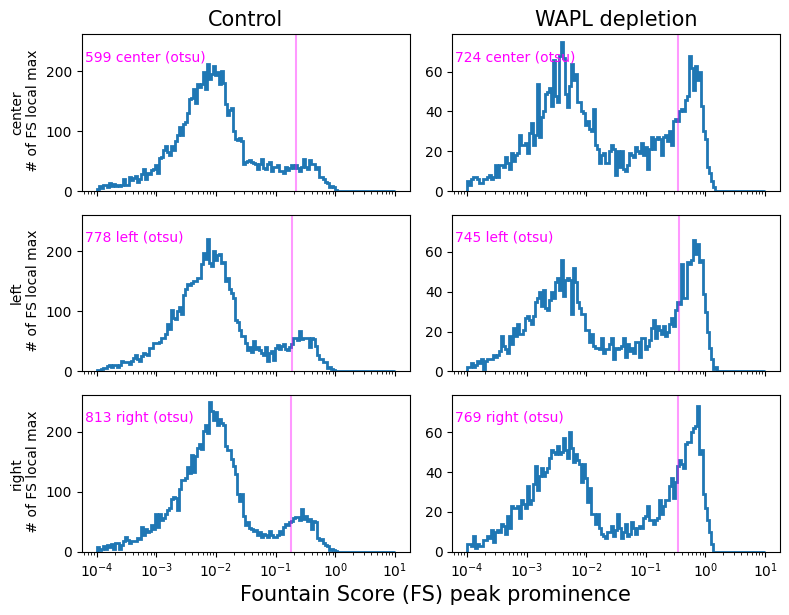

In [187]:
#ctr_f
#wapl_f
dat = [ctr_f,wapl_f]
histkwargs = dict(
    bins=10**np.linspace(-4,1,150),
    histtype='step',
    lw=2,
)
f, axs = plt.subplots(
    figsize=(8,6),
    nrows = 3,
    ncols = 2,
    sharex=True,sharey='col'
)
#ylabels = 5*['# of maxima']
ylabels = ['center','left','right']
subtitles = ['Control','WAPL depletion']



Alpha=0.4

for j in range(len(dat)):
    for i in range(3):
        val = dat[j][i]['FS_peaks']
        t_otsu = threshold_otsu(val.dropna().values)
        n_boundaries_otsu = (val.dropna()>t_otsu).sum()

        ax=axs[i,j]
        ax.hist(
            val,**histkwargs)
        ax.axvline(t_otsu, c='magenta',alpha=Alpha)
        ax.text(0.01, 0.9,
                f'{n_boundaries_otsu} '+ylabels[i]+' (otsu)',
                c='magenta',
                ha='left',
                va='top',
                transform=ax.transAxes)
        ax.set(
            xscale='log'
        )
            

        if j == 0:
            axs[i,j].set(
                ylabel=ylabels[i]+'\n # of FS local max'
            )
            
axs[0,0].set_title(subtitles[0],size=15)
axs[0,1].set_title(subtitles[1],size=15)
f.text(0.55, -0.01, 'Fountain Score (FS) peak prominence', ha='center',fontsize=15)

plt.tight_layout()

In [176]:
f.savefig('./ce10/plots/fontanka_step1_FS_peak_prominence_otsu.pdf',dpi=300,bbox_inches='tight')

In [188]:
########### load manual fountains windows ################
manual_center = bioframe.read_table('./ce10/avfountains/center_avfountain_window.bed',schema='bed3')
manual_left = bioframe.read_table('./ce10/avfountains/center_avfountain_window.bed',schema='bed3')
manual_right = bioframe.read_table('./ce10/avfountains/center_avfountain_window.bed',schema='bed3')
manuals = [manual_center,manual_left,manual_right]

In [189]:
########### assign a column to the fontanka #####
for i in range(len(manuals)):
    x = ctr_f[i]
    y = bioframe.closest(x, manual_center,cols1=('chrom','window_start','window_end'))
    a = y.distance == 0
    b = y.window_start == y.start_
    ctr_f[i].loc[:,'manual'] = np.logical_and(a,b)

    x = wapl_f[i]
    y = bioframe.closest(x, manual_center,cols1=('chrom','window_start','window_end'))
    a = y.distance == 0
    b = y.window_start == y.start_
    wapl_f[i].loc[:,'manual'] = np.logical_and(a,b)


    
#t.loc[:, 'manual'] = t.window_start == t.start_
#t

In [13]:
wapl_f[0][wapl_f[0].manual==True]


,Unnamed: 0,chrom,start,end,window_start,window_end,FS,FS_peaks,Scharr_box,is_not_noisy,is_peak_prominent,is_FS_above,is_fountain,manual
3976,3976,I,7952000,7954000,7852000,8054000,0.274710,0.532007,15.072024,True,True,True,True,True
12282,12282,II,9490000,9492000,9390000,9592000,0.630310,1.038327,23.060600,True,True,True,True,True
12812,12812,II,10550000,10552000,10450000,10652000,0.777935,1.293360,40.026012,False,True,True,False,True
23566,23566,IV,2994000,2996000,2894000,3096000,0.702420,1.258553,30.714100,False,True,True,False,True
24897,24897,IV,5656000,5658000,5556000,5758000,0.349860,0.546953,34.739785,False,True,True,False,True
26905,26905,IV,9672000,9674000,9572000,9774000,0.342801,0.522990,21.582354,True,True,True,True,True
30313,30313,IV,16488000,16490000,16388000,16590000,0.625335,0.011451,33.101698,False,False,True,False,True
31180,31180,V,728000,730000,628000,830000,0.624582,0.957598,38.129363,False,True,True,False,True
31306,31306,V,980000,982000,880000,1082000,0.765846,1.385215,30.266749,False,True,True,False,True
38648,38648,V,15664000,15666000,15564000,15766000,0.439007,0.686466,24.501597,True,True,True,True,True


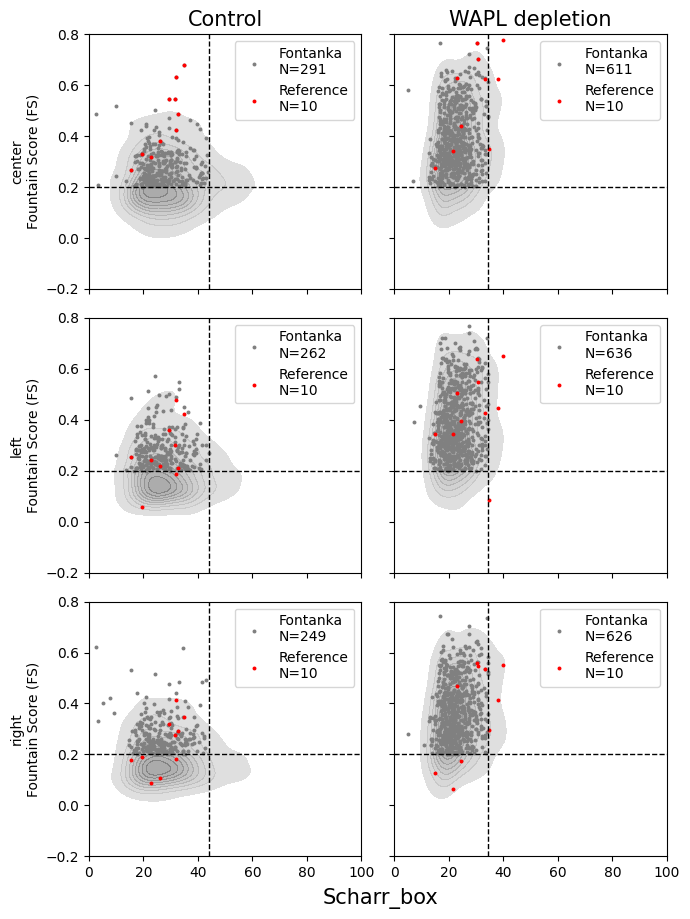

In [192]:
f, axs = plt.subplots(
    figsize=(7,9),
    nrows = 3,
    ncols = 2,
    sharex=True,sharey=True
)
dat = [ctr_f,wapl_f]

value_x = "Scharr_box"
value_y = "FS"


for j in range(len(dat)):
    for i in range(3):
        d0 = dat[j][i]
        d1 = d0[d0.is_peak_prominent == True]
        d2 = d1[d1.is_fountain == True]
        d3 = d0[d0.manual == True]
        ax=axs[i,j]
        sns.kdeplot(ax = ax, data=d1.dropna(subset="FS_peaks"), 
                    x=value_x, y=value_y, color='black', alpha=0.5, fill=True)
        sns.scatterplot(ax = ax,data=d2, 
                        x=value_x, y=value_y, color='grey', alpha=1, s=8, linewidth=0, label='Fontanka'+'\nN='+str(len(d2)))
        sns.scatterplot(ax = ax,data=d3, 
                        x=value_x, y=value_y, color='red', alpha=1, s=8, linewidth=0, label='Reference'+'\nN='+str(len(d3)))
        ax.set_xlim(0,100)
        ax.set_ylim(-0.2,0.8)
#        if i == 0 and j == 0:
#            ax.legend()
#        else:
#            ax.get_legend().remove()
        

        th_noise1 =  np.nanpercentile(d0.Scharr_box, th_noise)
        ax.plot([0, 100], [th_FS, th_FS],
                 '--', color='black', linewidth=1)
        ax.plot([th_noise1,th_noise1], [-0.2, 0.8], 
                 '--', color='black', linewidth=1)
        
        if j == 0:
            axs[i,j].set(
                ylabel=ylabels[i]+"\nFountain Score (FS)")
        ax.set(xlabel=None)

axs[0,0].set_title(subtitles[0],size=15)
axs[0,1].set_title(subtitles[1],size=15)

f.text(0.55, -0.01, 'Scharr_box', ha='center',fontsize=15)

plt.tight_layout()

In [193]:
f.savefig('./ce10/plots/fontanka_step2_FS0.2_Scharr95_cutoff.pdf',dpi=300,bbox_inches='tight')

In [181]:
############ overlap between control and wapl
## return based on a (ie control)
def overlappingregion(a,b,maxd):
    a0 = a[a.is_fountain == True]
    b0 = b[b.is_fountain == True]
    a0_mid = (a0.start + a0.end)/2
    b0_mid = (b0.start + b0.end)/2
    a0_bed3 = pd.DataFrame({'chrom': a0.chrom, 'start': a0_mid.astype(int), 'end': (a0_mid+1).astype(int)})
    b0_bed3 = pd.DataFrame({'chrom': b0.chrom, 'start': b0_mid.astype(int), 'end': (b0_mid+1).astype(int)})

    c = bioframe.closest(a0_bed3,b0_bed3,return_index=True)
    c0 = c[c.distance <= maxd]
    a_overlap = a0.iloc[c.index,:]
    return a_overlap




In [194]:
fount = []
for i in range(3):
    t = overlappingregion(ctr_f[i],wapl_f[i],10_000)
    print(len(t))
    fount.append(t)

fount[0][['chrom','start','end']].to_csv('./ce10/output/fontanka_FS0.2_Scharr95_ctr_wapl_center.bed',sep='\t',header=False,index=False)
fount[1][['chrom','start','end']].to_csv('./ce10/output/fontanka_FS0.2_Scharr95_ctr_wapl_left.bed',sep='\t',header=False,index=False)
fount[2][['chrom','start','end']].to_csv('./ce10/output/fontanka_FS0.2_Scharr95_ctr_wapl_right.bed',sep='\t',header=False,index=False)

291
262
249
